In [26]:
!pip install pandas numpy matplotlib seaborn scikit-learn tqdm


In [27]:
from google.colab import files
uploaded = files.upload()  # Upload user_transactions.json

Saving user-wallet-transactions.json to user-wallet-transactions (1).json


In [32]:
def extract_features(data):
    from collections import defaultdict
    import pandas as pd

    wallet_stats = defaultdict(lambda: {
        "deposit_count": 0,
        "borrow_count": 0,
        "repay_count": 0,
        "redeem_count": 0,
        "liquidation_count": 0,
        "total_actions": 0,
        "first_tx": float("inf"),
        "last_tx": 0,
    })

    for tx in data:
        wallet = tx.get("userWallet")  # ✅ Fixed field name
        if not wallet:
            continue
        action = tx.get("action", "").lower()
        timestamp = int(tx.get("timestamp", 0))

        if action == "deposit":
            wallet_stats[wallet]["deposit_count"] += 1
        elif action == "borrow":
            wallet_stats[wallet]["borrow_count"] += 1
        elif action == "repay":
            wallet_stats[wallet]["repay_count"] += 1
        elif action == "redeemunderlying":
            wallet_stats[wallet]["redeem_count"] += 1
        elif action == "liquidationcall":
            wallet_stats[wallet]["liquidation_count"] += 1

        wallet_stats[wallet]["total_actions"] += 1
        wallet_stats[wallet]["first_tx"] = min(wallet_stats[wallet]["first_tx"], timestamp)
        wallet_stats[wallet]["last_tx"] = max(wallet_stats[wallet]["last_tx"], timestamp)

    rows = []
    for wallet, stats in wallet_stats.items():
        duration_days = (stats["last_tx"] - stats["first_tx"]) / (60 * 60 * 24)
        duration_days = duration_days if duration_days > 0 else 1

        borrow_count = stats["borrow_count"]
        repay_ratio = stats["repay_count"] / borrow_count if borrow_count > 0 else 1.0

        rows.append({
            "wallet": wallet,
            "deposit_count": stats["deposit_count"],
            "borrow_count": stats["borrow_count"],
            "repay_count": stats["repay_count"],
            "redeem_count": stats["redeem_count"],
            "liquidation_count": stats["liquidation_count"],
            "total_actions": stats["total_actions"],
            "duration_days": duration_days,
            "repay_ratio": repay_ratio,
        })

    return pd.DataFrame(rows)


In [33]:
import json

with open("user-wallet-transactions.json", "r") as f:
    raw_data = json.load(f)

# See first 3 records
raw_data[:3]
wallet_df = extract_features(raw_data)
print("✅ Extracted rows:", len(wallet_df))
print(wallet_df.columns)
wallet_df.head()







✅ Extracted rows: 3497
Index(['wallet', 'deposit_count', 'borrow_count', 'repay_count',
       'redeem_count', 'liquidation_count', 'total_actions', 'duration_days',
       'repay_ratio'],
      dtype='object')


,wallet,deposit_count,borrow_count,repay_count,redeem_count,liquidation_count,total_actions,duration_days,repay_ratio
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,1,0,0,0,0,1,1.000000,1.000000
1,0x000000000051d07a4fb3bd10121a343d85818da6,1,0,0,0,0,1,1.000000,1.000000
2,0x000000000096026fb41fc39f9875d164bd82e2dc,2,0,0,0,0,2,7.574132,1.000000
3,0x0000000000e189dd664b9ab08a33c4839953852c,0,0,0,17,0,17,129.327766,1.000000
4,0x0000000002032370b971dabd36d72f3e5a7bf1ee,250,15,4,130,0,399,132.865903,0.266667


In [43]:
def improved_score(df):
    df = df.copy()

    # Fill NaN with 0 to avoid errors
    df = df.fillna(0)

    # Normalize features
    df["repay_ratio"] = df["repay_ratio"].clip(0, 1)
    df["activity_score"] = df["total_actions"] / df["total_actions"].max()
    df["longevity"] = df["duration_days"] / df["duration_days"].max()
    df["risk_factor"] = df["liquidation_count"] / (df["total_actions"] + 1)

    # Weighted scoring logic
    df["score"] = (
        df["repay_ratio"] * 0.3 +
        df["activity_score"] * 0.3 +
        df["longevity"] * 0.2 +
        (1 - df["risk_factor"]) * 0.2
    )

    # Normalize to 0-1000
    df["credit_score"] = (df["score"] / df["score"].max() * 1000).astype(int)

    return df


In [44]:
wallet_df = improved_score(wallet_df)
wallet_df.to_csv("wallet_scores.csv", index=False)
wallet_df.head()


,wallet,deposit_count,borrow_count,repay_count,redeem_count,liquidation_count,total_actions,duration_days,repay_ratio,activity_score,longevity,risk_factor,score,credit_score
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,1,0,0,0,0,1,1.000000,1.000000,0.000070,0.006502,0.0,0.501321,566
1,0x000000000051d07a4fb3bd10121a343d85818da6,1,0,0,0,0,1,1.000000,1.000000,0.000070,0.006502,0.0,0.501321,566
2,0x000000000096026fb41fc39f9875d164bd82e2dc,2,0,0,0,0,2,7.574132,1.000000,0.000140,0.049249,0.0,0.509892,575
3,0x0000000000e189dd664b9ab08a33c4839953852c,0,0,0,17,0,17,129.327766,1.000000,0.001192,0.840924,0.0,0.668542,754
4,0x0000000002032370b971dabd36d72f3e5a7bf1ee,250,15,4,130,0,399,132.865903,0.266667,0.027971,0.863930,0.0,0.461177,520


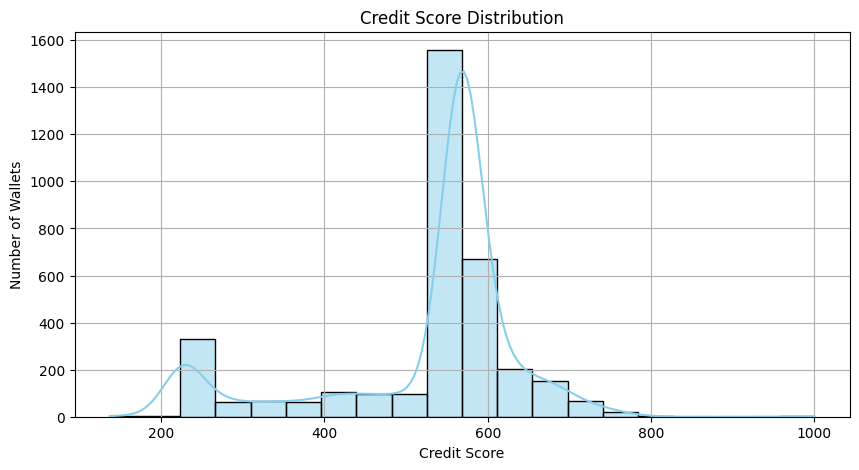

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.histplot(wallet_df["credit_score"], bins=20, kde=True, color="skyblue")
plt.title("Credit Score Distribution")
plt.xlabel("Credit Score")
plt.ylabel("Number of Wallets")
plt.grid(True)
plt.show()


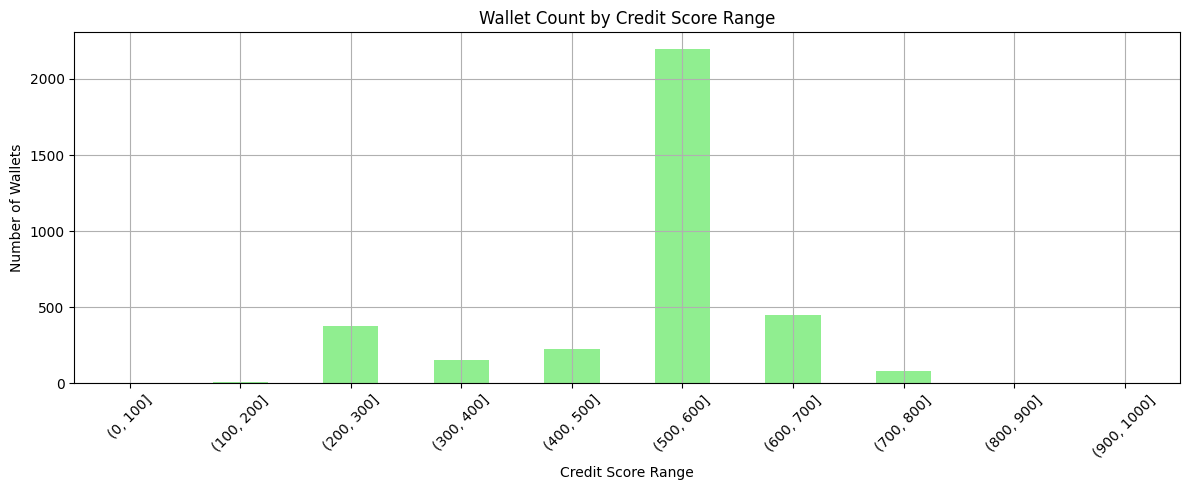

score_range
(0, 100]          0
(100, 200]        9
(200, 300]      380
(300, 400]      156
(400, 500]      228
(500, 600]     2196
(600, 700]      449
(700, 800]       78
(800, 900]        0
(900, 1000]       1
Name: count, dtype: int64
                                          wallet  deposit_count  borrow_count  \
3322  0x05c9db563db8e38cc2899297da41ce430b61a484              0             0   

      repay_count  redeem_count  liquidation_count  total_actions  \
3322            0         14265                  0          14265   

      duration_days  repay_ratio  activity_score  longevity  risk_factor  \
3322      65.880775          1.0             1.0   0.428375          0.0   

         score  credit_score  score_range  
3322  0.885675          1000  (900, 1000]  


In [49]:


# Load wallet scores
wallet_df = pd.read_csv("wallet_scores.csv")

# Create credit score ranges
score_bins = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
wallet_df["score_range"] = pd.cut(wallet_df["credit_score"], bins=score_bins)

# Count wallets per range
range_counts = wallet_df["score_range"].value_counts().sort_index()

# Plot distribution
plt.figure(figsize=(12, 5))
range_counts.plot(kind="bar", color="lightgreen")
plt.title("Wallet Count by Credit Score Range")
plt.xlabel("Credit Score Range")
plt.ylabel("Number of Wallets")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Save top wallets with scores ≥ 800
high_score_wallets = wallet_df[wallet_df["credit_score"] >= 800]
high_score_wallets.to_csv("top_credit_wallets.csv", index=False)

# Save final score file
wallet_df.to_csv("final_wallet_scores.csv", index=False)

# Display counts and top examples
print(range_counts)
print(high_score_wallets.head())
